In [1]:
!pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import pandas as pd
import math
import os
import statsmodels.api as sm
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold, TimeSeriesSplit, GroupKFold, StratifiedKFold
from sklearn.linear_model import LinearRegression
import joblib
from sklearn.metrics import mean_squared_error, r2_score
from bayes_opt import BayesianOptimization


import warnings
warnings.filterwarnings('ignore')

In [7]:
# Set the seed for both Python's hash function and NumPy's random number generator to a specified value.
def seed_everything(seed: int) -> None:
    # Set the seed for Python's hash function
    os.environ['PYTHONHASHSEED'] = str(seed)  
    # Set the seed for NumPy's random number generator
    np.random.seed(seed)  

# Set the seed to 4 and call the seed_everything() function to set the seed for Python and NumPy
SEED=4
seed_everything(SEED)

In [8]:
df4=pd.read_csv('/content/drive/MyDrive/DF4.csv')

In [ ]:
df4.shape

(104427, 152)

In [12]:
all_stock_name=df4['windCode'].unique()

In [13]:
all_stock_name.shape

(299,)

In [15]:
stock_for_predict_model = np.random.choice(all_stock_name, size=219, replace=False)
DF = df4[df4['windCode'].isin(stock_for_predict_model)]
backtest_data = df4[df4['windCode'].isin(stock_for_predict_model)]

In [ ]:
backtest_data.to_csv('/content/drive/MyDrive/backtest_data.csv')

### 引入下一天的return作为预测目标，删除了最后一天的数据避免NAN

In [16]:
# Create a new column called Next-Return
DF1=DF.copy()
DF1["Next-Return"] = DF1.groupby('windCode')['return'].shift(-1)

# Delete the last day of data for each stock
DF1 = DF1.groupby("windCode").apply(lambda x: x.iloc[:-1]).reset_index(drop=True).sort_values(['windCode', 'tradingDate'])

In [ ]:
DF1.isnull().sum()

tradingDate    0
windCode       0
return         0
alpha001       0
alpha002       0
              ..
alpha187       0
alpha189       0
alpha190       0
alpha191       0
Next-Return    0
Length: 153, dtype: int64

In [ ]:
pd.set_option('display.max_rows', 200)

In [17]:
DF1 = DF1[DF1['alpha114'] != np.inf]

In [18]:
inf_codes = DF.loc[np.isinf(DF['alpha114']), ['windCode', 'tradingDate']].drop_duplicates()

In [ ]:
inf_codes

,windCode,tradingDate
28233,002916.XSHE,2021-11-01
71620,601155.XSHG,2022-11-14


In [19]:
DF[DF['windCode']=='002916.XSHE']['alpha114']

28233         inf
28234   -1.462852
28235    0.768426
28236    0.273753
28237    0.331020
           ...   
28578   -0.270633
28579   -1.201486
28580    2.497380
28581    0.380301
28582    0.496823
Name: alpha114, Length: 350, dtype: float64

In [22]:
DF1

,tradingDate,windCode,return,alpha001,alpha002,alpha003,alpha004,alpha005,alpha006,alpha007,...,alpha175,alpha176,alpha177,alpha179,alpha184,alpha187,alpha189,alpha190,alpha191,Next-Return
0,2021-11-01,000002.XSHE,-0.109830,0.605654,-0.726960,-3.89,1.0,-0.870388,-0.373589,0.875937,...,0.858333,-0.319536,30.0,0.035131,1.412978,5.05,0.856389,0.035531,-0.678237,-0.472381
9,2021-11-02,000002.XSHE,0.585788,0.585788,0.711568,-3.46,1.0,-0.557370,-0.299314,1.228885,...,0.745000,-0.567052,25.0,0.057665,1.584224,3.71,1.034722,0.615115,-0.565001,-0.735001
16,2021-11-03,000002.XSHE,0.624190,0.624190,-1.537368,-2.10,1.0,-0.075378,-0.262821,0.000809,...,0.688333,-0.511373,20.0,0.101603,1.049302,2.73,0.985556,0.344756,-0.937513,0.273934
18,2021-11-04,000002.XSHE,0.416719,0.416719,0.239301,-1.49,-1.0,0.562500,-0.162431,0.014245,...,0.646667,-0.656946,15.0,0.023408,1.294269,2.61,0.898056,0.334116,0.504886,0.433761
19,2021-11-05,000002.XSHE,0.433761,0.433761,1.246120,-1.20,-1.0,0.395285,-0.183897,0.004887,...,0.583333,-0.815396,10.0,0.016406,1.412032,2.40,0.750000,0.333648,0.462567,0.091167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76211,2023-03-30,688981.XSHG,-0.578969,-0.578969,0.776609,-1.85,-1.0,-0.480384,-0.361263,0.081495,...,1.910000,0.694700,60.0,0.159272,0.938333,22.44,1.302222,-1.460825,-0.362543,-0.584089
76212,2023-03-31,688981.XSHG,-0.584089,-0.584089,-0.976433,-2.37,-1.0,-0.537086,-0.368677,0.563547,...,1.736667,0.682992,55.0,0.067713,0.500000,22.99,1.280278,-1.444808,-0.386471,-0.015891
76217,2023-04-03,688981.XSHG,-0.637678,-0.637678,-0.612233,3.86,1.0,-0.769800,-0.821226,0.505928,...,2.253333,0.821338,100.0,0.178969,0.406667,26.54,1.798056,-1.825900,-1.544389,-0.755875
76218,2023-04-04,688981.XSHG,-0.755875,-0.755875,0.659885,7.81,-1.0,-0.769800,-0.717998,0.616085,...,2.598333,0.833917,100.0,0.301552,0.393333,30.12,2.332222,-1.703764,0.311038,-0.718851


In [23]:
DF1.to_csv('/content/drive/MyDrive/DF1.csv')

In [ ]:
def feval_rmse(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'rmse', mean_squared_error(y_true, y_pred), False

def feval_pearsonr(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'pearsonr', stats.pearsonr(y_true, y_pred)[0], True

def calc_spread_return_per_day(df, portfolio_size=200, toprank_weight_ratio=2):
    assert df['Rank'].min() == 0
    assert df['Rank'].max() == len(df['Rank']) - 1
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
    short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
    return purchase - short

def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size=200, toprank_weight_ratio=2):
    buf = df.groupby('Date').apply(calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio#, buf

def add_rank(df):
    df["Rank"] = df.groupby("Date")["Target"].rank(ascending=False, method="first") - 1 
    df["Rank"] = df["Rank"].astype("int")
    return df

def check_score(df,preds,Securities_filter=[]):
    tmp_preds=df[['Date','SecuritiesCode']].copy()
    tmp_preds['Target']=preds
    
    #Rank Filter. Calculate median for this date and assign this value to the list of Securities to filter.
    tmp_preds['target_mean']=tmp_preds.groupby("Date")["Target"].transform('median')
    tmp_preds.loc[tmp_preds['SecuritiesCode'].isin(Securities_filter),'Target']=tmp_preds['target_mean']
    
    tmp_preds = add_rank(tmp_preds)
    df['Rank']=tmp_preds['Rank']
    score=round(calc_spread_return_sharpe(df, portfolio_size= 200, toprank_weight_ratio= 2),5)
    score_mean=round(df.groupby('Date').apply(calc_spread_return_per_day, 200, 2).mean(),5)
    score_std=round(df.groupby('Date').apply(calc_spread_return_per_day, 200, 2).std(),5)
    print(f'Competition_Score:{score}, rank_score_mean:{score_mean}, rank_score_std:{score_std}')

In [24]:
#split dataset in features and target variable
X_column=list(DF1.filter(regex='^alpha').columns)
X = DF1[X_column] # alphas
y = DF1['Next-Return'] # tommorrow return
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

### 普通方法判断重要因子

In [25]:
#Train the LGBM model using cross-validation
model = lgb.LGBMRegressor(random_state=4)
model.fit(X_train, y_train)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f'Cross-validated Mean Squared Error: {np.mean(np.abs(cv_scores))}')


Cross-validated Mean Squared Error: 0.1277587435424344


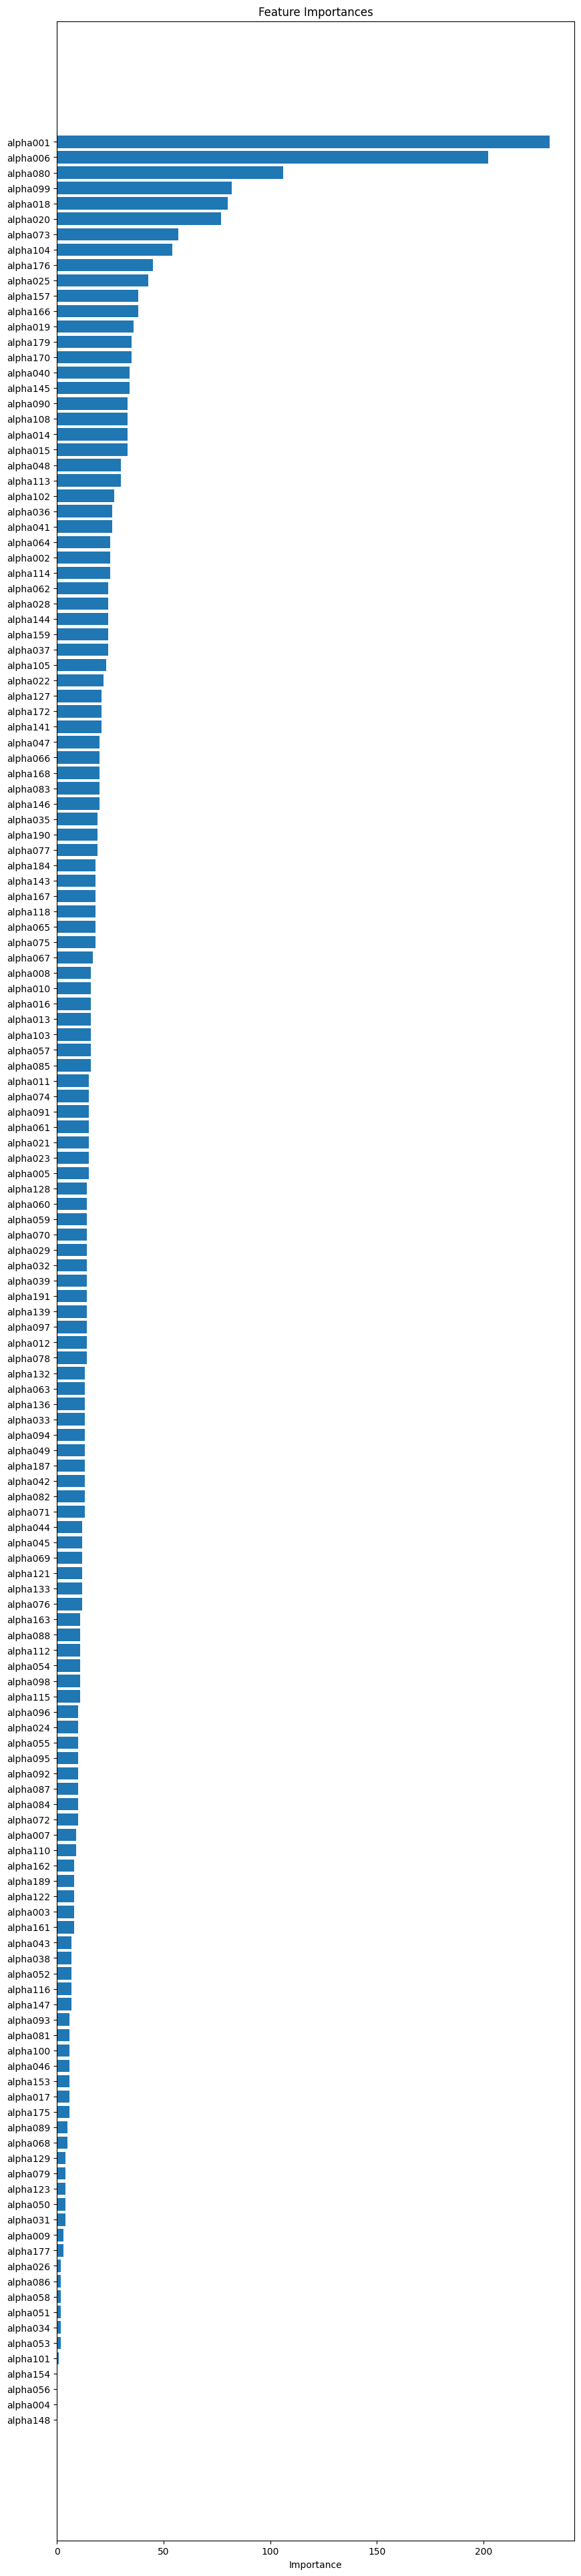

In [26]:
#Calculate the feature importance and plot
feature_importances = model.feature_importances_
sorted_idx = feature_importances.argsort()

plt.figure(figsize=(10, 49))
plt.barh(X.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

In [27]:
feature_importances[sorted_idx]

array([  0,   0,   0,   0,   1,   2,   2,   2,   2,   2,   2,   3,   3,
         4,   4,   4,   4,   4,   5,   5,   6,   6,   6,   6,   6,   6,
         6,   7,   7,   7,   7,   7,   8,   8,   8,   8,   8,   9,   9,
        10,  10,  10,  10,  10,  10,  10,  10,  11,  11,  11,  11,  11,
        11,  12,  12,  12,  12,  12,  12,  13,  13,  13,  13,  13,  13,
        13,  13,  13,  13,  14,  14,  14,  14,  14,  14,  14,  14,  14,
        14,  14,  14,  15,  15,  15,  15,  15,  15,  15,  16,  16,  16,
        16,  16,  16,  16,  17,  18,  18,  18,  18,  18,  18,  19,  19,
        19,  20,  20,  20,  20,  20,  21,  21,  21,  22,  23,  24,  24,
        24,  24,  24,  25,  25,  25,  26,  26,  27,  30,  30,  33,  33,
        33,  33,  34,  34,  35,  35,  36,  38,  38,  43,  45,  54,  57,
        77,  80,  82, 106, 202, 231], dtype=int32)

In [28]:
feature_importances.sort()
feature_importances

array([  0,   0,   0,   0,   1,   2,   2,   2,   2,   2,   2,   3,   3,
         4,   4,   4,   4,   4,   5,   5,   6,   6,   6,   6,   6,   6,
         6,   7,   7,   7,   7,   7,   8,   8,   8,   8,   8,   9,   9,
        10,  10,  10,  10,  10,  10,  10,  10,  11,  11,  11,  11,  11,
        11,  12,  12,  12,  12,  12,  12,  13,  13,  13,  13,  13,  13,
        13,  13,  13,  13,  14,  14,  14,  14,  14,  14,  14,  14,  14,
        14,  14,  14,  15,  15,  15,  15,  15,  15,  15,  16,  16,  16,
        16,  16,  16,  16,  17,  18,  18,  18,  18,  18,  18,  19,  19,
        19,  20,  20,  20,  20,  20,  21,  21,  21,  22,  23,  24,  24,
        24,  24,  24,  25,  25,  25,  26,  26,  27,  30,  30,  33,  33,
        33,  33,  34,  34,  35,  35,  36,  38,  38,  43,  45,  54,  57,
        77,  80,  82, 106, 202, 231], dtype=int32)

In [29]:
X.columns[sorted_idx]

Index(['alpha148', 'alpha004', 'alpha056', 'alpha154', 'alpha101', 'alpha053',
       'alpha034', 'alpha051', 'alpha058', 'alpha086',
       ...
       'alpha025', 'alpha176', 'alpha104', 'alpha073', 'alpha020', 'alpha018',
       'alpha099', 'alpha080', 'alpha006', 'alpha001'],
      dtype='object', length=149)

### lasso判断重要因子

In [30]:
from sklearn.preprocessing import StandardScaler
lasso = Lasso(alpha=0.01)

# Scale the input data X
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
lasso.fit(X_train_scaled, y_train)

# Get important features
important_features_lasso = X.columns[lasso.coef_ != 0]
X_train_filtered = X_train[important_features_lasso]
X_test_filtered = X_test[important_features_lasso]

In [31]:
print(np.isinf(X_train).any())

alpha001    False
alpha002    False
alpha003    False
alpha004    False
alpha005    False
            ...  
alpha184    False
alpha187    False
alpha189    False
alpha190    False
alpha191    False
Length: 149, dtype: bool


In [32]:
print(important_features_lasso)

Index(['alpha001', 'alpha008', 'alpha010', 'alpha019', 'alpha041', 'alpha073',
       'alpha075', 'alpha090', 'alpha099', 'alpha104', 'alpha157', 'alpha170',
       'alpha176'],
      dtype='object')


### 二次训练

#### 常规特征筛选结果

In [33]:
#Train the LGBM model again based on important features
# Select top n important features, you can adjust this value
n = 50
important_features = X.columns[sorted_idx][-n:]

X_train_important = X_train[important_features]
X_test_important = X_test[important_features]

model_important = lgb.LGBMRegressor(random_state=4)
model_important.fit(X_train_important, y_train)

cv_scores_important = cross_val_score(model_important, X_train_important, y_train, cv=5, scoring='neg_mean_squared_error')
print(f'Cross-validated Mean Squared Error (Important Features): {np.mean(np.abs(cv_scores_important))}')



Cross-validated Mean Squared Error (Important Features): 0.12707573816234966


In [34]:
important_features

Index(['alpha167', 'alpha143', 'alpha184', 'alpha077', 'alpha190', 'alpha035',
       'alpha146', 'alpha083', 'alpha168', 'alpha066', 'alpha047', 'alpha141',
       'alpha172', 'alpha127', 'alpha022', 'alpha105', 'alpha037', 'alpha159',
       'alpha144', 'alpha028', 'alpha062', 'alpha114', 'alpha002', 'alpha064',
       'alpha041', 'alpha036', 'alpha102', 'alpha113', 'alpha048', 'alpha015',
       'alpha014', 'alpha108', 'alpha090', 'alpha145', 'alpha040', 'alpha170',
       'alpha179', 'alpha019', 'alpha166', 'alpha157', 'alpha025', 'alpha176',
       'alpha104', 'alpha073', 'alpha020', 'alpha018', 'alpha099', 'alpha080',
       'alpha006', 'alpha001'],
      dtype='object')

In [37]:
for i in range(50,81,5):
  important_features = X.columns[sorted_idx][-n:]

  X_train_important = X_train[important_features]
  X_test_important = X_test[important_features]

  model_important = lgb.LGBMRegressor(random_state=4)
  cv_scores_important = cross_val_score(model_important, X_train_important, y_train, cv=5, scoring='neg_mean_squared_error')
  print('Cross-validated Mean Squared Error (Important Features): {} ,n is: {} '.format(np.mean(np.abs(cv_scores_important)), i))

  model_important.fit(X_train_important, y_train)

Cross-validated Mean Squared Error (Important Features): 0.12707573816234966 ,n is: 50 
Cross-validated Mean Squared Error (Important Features): 0.12707573816234966 ,n is: 55 
Cross-validated Mean Squared Error (Important Features): 0.12707573816234966 ,n is: 60 
Cross-validated Mean Squared Error (Important Features): 0.12707573816234966 ,n is: 65 
Cross-validated Mean Squared Error (Important Features): 0.12707573816234966 ,n is: 70 
Cross-validated Mean Squared Error (Important Features): 0.12707573816234966 ,n is: 75 
Cross-validated Mean Squared Error (Important Features): 0.12707573816234966 ,n is: 80 


#### LASSO特征筛选结果

In [38]:
model_important_lasso = lgb.LGBMRegressor(random_state=4)
cv_scores_important = cross_val_score(model_important_lasso, X_train_filtered, y_train, cv=5, scoring='neg_mean_squared_error')
print(f'Cross-validated Mean Squared Error (Important Features): {np.mean(np.abs(cv_scores_important))}')

model_important_lasso.fit(X_train_important, y_train)

Cross-validated Mean Squared Error (Important Features): 0.13216656933570897


LGBMRegressor(random_state=4)

### 贝叶斯搜索超参数

In [39]:
kf = KFold(n_splits=5, shuffle=True, random_state=4)
def lgbm_cv_score(max_depth, learning_rate, n_estimators, num_leaves, min_child_samples, subsample, colsample_bytree, reg_alpha, reg_lambda):
    lgbm_params = {
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'num_leaves': int(num_leaves),
        'min_child_samples': int(min_child_samples),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'objective': 'regression',
        'n_jobs': -1,
        'random_state': 4,
    }

    lgbm_model = LGBMRegressor(**lgbm_params)
    cv_scores = []

    for train_index, val_index in kf.split(X_train_important):
        X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]

        lgbm_model.fit(X_train_cv, y_train_cv, eval_set=[(X_val_cv, y_val_cv)], early_stopping_rounds=10, verbose=0)
        cv_scores.append(mean_squared_error(y_val_cv, lgbm_model.predict(X_val_cv))**0.5)

    return -np.mean(cv_scores)

In [40]:
from lightgbm import LGBMRegressor
bounds = {
    'max_depth': (5, 10),
    'learning_rate': (0.01, 0.1),
    'n_estimators': (50, 200),
    'num_leaves': (15, 50),
    'min_child_samples': (5, 30),
    'subsample': (0.6, 1),
    'colsample_bytree': (0.6, 1),
    'reg_alpha': (0, 1), 
    'reg_lambda': (0, 1),
}

optimizer = BayesianOptimization(f=lgbm_cv_score, pbounds=bounds, random_state=4)
optimizer.maximize(init_points=10, n_iter=15)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | -0.3576   | 0.9868    | 0.05925   | 9.863     | 22.87     | 154.7     | 22.56     | 0.9763    | 0.00623   | 0.7012    |
| 2         | -0.3572   | 0.7739    | 0.08014   | 5.988     | 26.57     | 197.5     | 20.73     | 0.5973    | 0.008986  | 0.7546    |
| 3         | -0.3558   | 0.6177    | 0.0961    | 7.181     | 28.72     | 167.9     | 45.32     | 0.1732    | 0.07495   | 0.8403    |
| 4         | -0.356    | 0.6672    | 0.076     | 7.042     | 18.2      | 190.6     | 33.26     | 0.1082    | 0.1582    | 0.8181    |
| 5         | -0.3572   | 0.8098    | 0.06738   | 7.007     | 21.25     | 109.5     | 36.84     | 0.7674    | 0.179     | 0.7502    |
| 6         | -0.3565   | 0.801     | 0.0718    | 6.268     | 

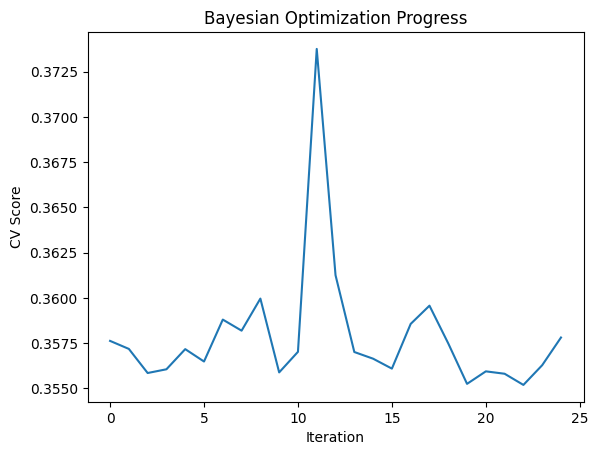

In [45]:
targets = [-r['target'] for r in optimizer.res]
plt.plot(targets)
plt.xlabel('Iteration')
plt.ylabel('CV Score')
plt.title('Bayesian Optimization Progress')
plt.show()

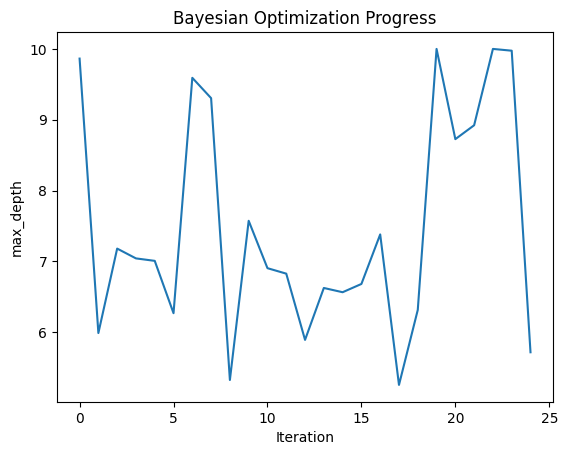

In [46]:
# Extract the values of 'max_depth' from the optimizer results
max_depths = [r['params']['max_depth'] for r in optimizer.res]

# Create a line plot showing how 'max_depth' changes over time
plt.plot(max_depths)
plt.xlabel('Iteration')
plt.ylabel('max_depth')
plt.title('Bayesian Optimization Progress')
plt.show()

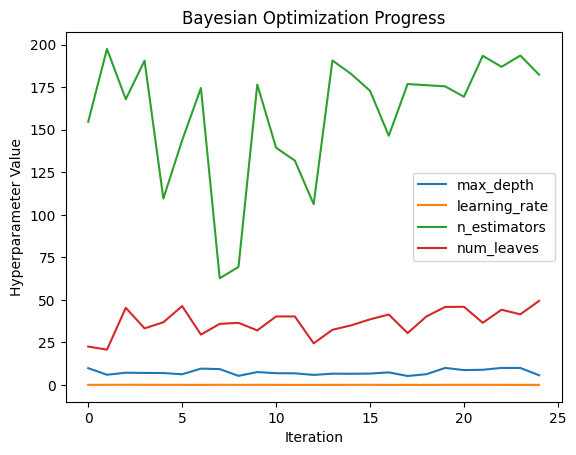

In [47]:
# Define a list of hyperparameters to plot
hyperparams = ['max_depth', 'learning_rate', 'n_estimators', 'num_leaves']

# Extract the values of each hyperparameter from the optimizer results
values = {}
for param in hyperparams:
    values[param] = [r['params'][param] for r in optimizer.res]

# Create a line plot for each hyperparameter
fig, ax = plt.subplots()
for param in hyperparams:
    ax.plot(values[param], label=param)
ax.set_xlabel('Iteration')
ax.set_ylabel('Hyperparameter Value')
ax.set_title('Bayesian Optimization Progress')
ax.legend()
plt.show()

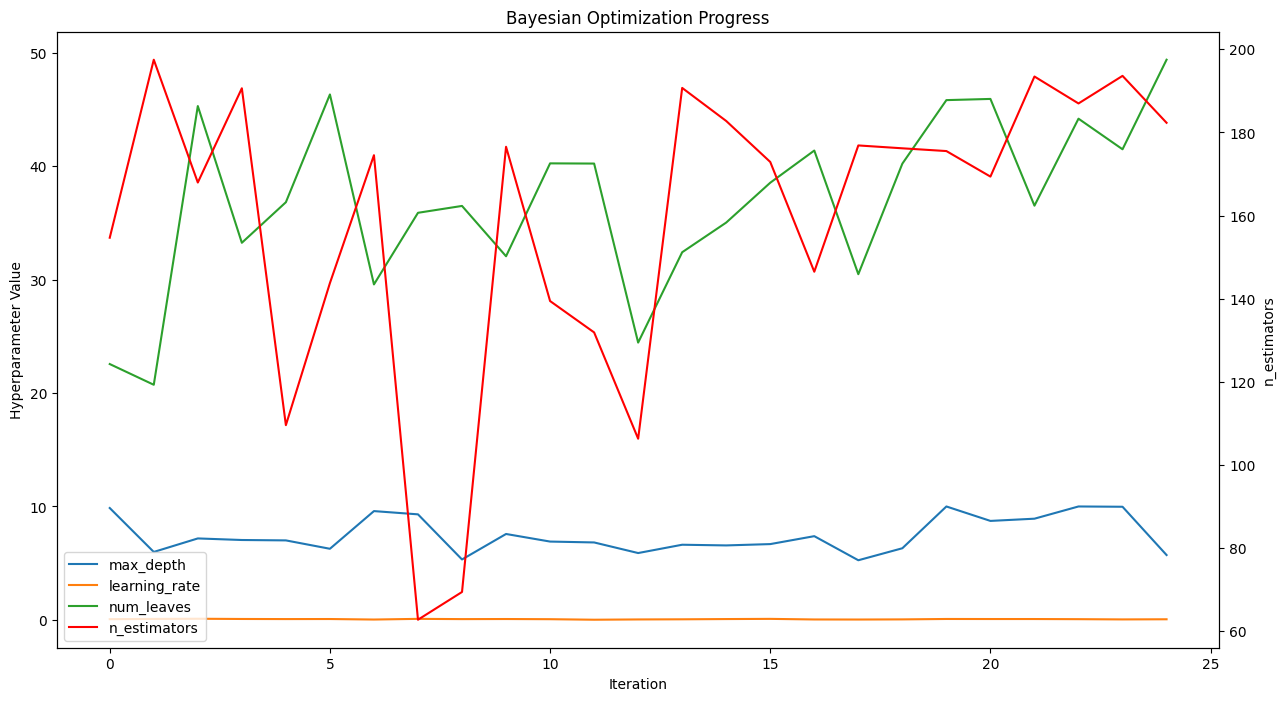

In [63]:
# Define a list of hyperparameters to plot
hyperparams = ['max_depth', 'learning_rate', 'num_leaves']

# Extract the values of each hyperparameter from the optimizer results
values = {}
for param in hyperparams:
    values[param] = [r['params'][param] for r in optimizer.res]

# Extract the values of 'n_estimators' from the optimizer results
n_estimators = [r['params']['n_estimators'] for r in optimizer.res]

# Create a line plot for each hyperparameter, with 'n_estimators' on a second y-axis
fig, ax1 = plt.subplots(figsize=(15,8))


# Plot the hyperparameters on the first y-axis (left)
for param in hyperparams:
    ax1.plot(values[param], label=param)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Hyperparameter Value')

# Create a second y-axis (right) for 'n_estimators'
ax2 = ax1.twinx()
ax2.plot(n_estimators, color='red', label='n_estimators')
ax2.set_ylabel('n_estimators')

# Display the legend for both y-axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2)

# Set the title for the plot
plt.title('Bayesian Optimization Progress')

# Show the plot
plt.show()

### 训练模型&early stop

In [64]:
optimized_params = optimizer.max['params']
optimized_params['max_depth'] = int(optimized_params['max_depth'])
optimized_params['n_estimators'] = int(optimized_params['n_estimators'])
optimized_params['num_leaves'] = int(optimized_params['num_leaves'])
optimized_params['min_child_samples'] = int(optimized_params['min_child_samples'])

final_lgbm_model = LGBMRegressor(**optimized_params)
final_lgbm_model.fit(X_train_important, y_train, eval_set=[(X_test_important, y_test)], early_stopping_rounds=10, verbose=0)


LGBMRegressor(colsample_bytree=0.6118670580789786,
              learning_rate=0.05855690903401396, max_depth=10,
              min_child_samples=22, n_estimators=186, num_leaves=44,
              reg_alpha=0.5646887677994711, reg_lambda=0.09601739979773136,
              subsample=0.7438848878727043)

### 模型评价

In [65]:
y_pred = final_lgbm_model.predict(X_test_important)
test_rmse = mean_squared_error(y_test, y_pred)**0.5
print(f"Test RMSE: {test_rmse}")

Test RMSE: 0.3515011604919131


In [66]:
#Save the trained model:
booster = final_lgbm_model.booster_
booster.save_model('final_lgbm_model_original.txt')

#uploaded = files.upload()
#loaded_lgbm_model = lgb.Booster(model_file='lgbm_model.txt')